# DonorsChoose Application Screening

Data Source: https://www.kaggle.com/c/donorschoose-application-screening

# 1.Introduction

#### About DonorsChoose:<br>

Founded in 2000 by a high school teacher in the Bronx, DonorsChoose.org empowers public school teachers from across the country to request much-needed materials and experiences for their students. At any given time, there are thousands of classroom requests that can be brought to life with a gift of any amount.

#### Their Mission:<br>

They make it easy for anyone to help a classroom in need, moving them closer to a nation where students in every community have the tools and experiences they need for a great education.

#### Objective:<br>

The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

# 2.About Data

The dataset contains information from teachers' project applications to DonorsChoose.org including teacher attributes, school attributes, and the project proposals including application essays.

#### Files:<br>
Data is provided in Two Files:<br>
<ul>
    <li>train.csv - the training set</li>
    <li>resources.csv - resources requested by each proposal; joins with train.csv on id</li>
</ul>

#### Data Fields:<br>

##### Train Data Fields

<ul>
<li><strong>id</strong> - unique id of the project application</li>
<li><strong>teacher_id</strong>&nbsp;- id of the teacher submitting the application</li>
<li><strong>teacher_prefix</strong>&nbsp;- title of the teacher's name (Ms., Mr., etc.)</li>
<li><strong>school_state</strong>&nbsp;- US state of the teacher's school</li>
<li><strong>project_submitted_datetime</strong>&nbsp;- application submission timestamp</li>
<li><strong>project_grade_category</strong>&nbsp;- school grade levels (PreK-2, 3-5, 6-8, and 9-12)</li>
<li><strong>project_subject_categories</strong>&nbsp;- category of the project (e.g., "Music &amp; The Arts")</li>
<li><strong>project_subject_subcategories</strong>&nbsp;- sub-category of the project (e.g., "Visual Arts")</li>
<li><strong>project_title</strong>&nbsp;- title of the project</li>
<li><strong>project_essay_1</strong>&nbsp;- first essay<sup>*</sup></li>
<li><strong>project_essay_2</strong>&nbsp;- second essay<sup>*</sup></li>
<li><strong>project_essay_3</strong>&nbsp;- third essay<sup>*</sup></li>
<li><strong>project_essay_4</strong>&nbsp;- fourth essay<sup>*</sup></li>
<li><strong>project_resource_summary</strong>&nbsp;- summary of the resources needed for the project</li>
<li><strong>teacher_number_of_previously_posted_projects</strong>&nbsp;- number of previously posted applications by the submitting teacher</li>
<li><strong>project_is_approved</strong>&nbsp;- whether DonorsChoose proposal was accepted (0="rejected", 1="accepted"); <code>train.csv</code> only</li>
</ul>


<ul>
<li><strong>project_essay_1</strong>: "Introduce us to your classroom"</li>
<li><strong>project_essay_2</strong>: "Tell us more about your students"</li>
<li><strong>project_essay_3</strong>: "Describe how your students will use the materials you're requesting"</li>
<li><strong>project_essay_4</strong>: "Close by sharing why your project will make a difference"</li>
</ul>



<p>Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:</p>

<ul>
<li><strong>project_essay_1</strong>: "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li><strong>project_essay_2</strong>: "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
</ul>


##### Resources Data Fields

<ul>
<li><strong>id</strong> - unique id of the project application; joins with <code>train.csv</code> on <code>id</code></li>
<li><strong>description</strong> - description of the resource requested</li>
<li><strong>quantity</strong> - quantity of resource requested</li>
<li><strong>price</strong> - price of resource requested</li>
</ul>


## 2.1 Loading Data

In [1]:
%matplotlib inline
from datetime import datetime

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import warnings
warnings.filterwarnings("ignore")

import pickle
import re

import string
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from sklearn.preprocessing import scale,StandardScaler

from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
from sklearn import tree
from sklearn.decomposition import TruncatedSVD
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

In [37]:
train_df = pd.read_csv('train.csv')

In [38]:
train_df.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [39]:
train_df.shape

(182080, 16)

In [40]:
resource_df = pd.read_csv('resources.csv')

In [41]:
resource_df.shape

(1541272, 4)

### Merging Train Data with Resource

In [47]:
train_res_df = pd.merge(train_df,resource_df,on='id',how='left')

In [48]:
train_res_df.shape

(1081830, 19)

> Observation: There are around 10lakh data points with 19 features in the training data

# 3. Exploratory Data Analysis(EDA)

In [43]:
train_res_df.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,quantity,price
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1,Apple - iPod nano� 16GB MP3 Player (8th Genera...,3,149.99
1,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1,Apple - iPod nano� 16GB MP3 Player (8th Genera...,3,149.99
2,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,Reebok Girls' Fashion Dance Graphic T-Shirt - ...,20,20.00
3,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1,3doodler Start Full Edu Bundle,1,469.99
4,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0,BALL PG 4'' POLY SET OF 6 COLORS,1,18.95


## 3.1 Percentage of Projects Approved/Rejected

In [13]:
approved_percent = train_res_df[train_res_df['project_is_approved']==1].shape[0]/train_res_df.shape[0]*100;
print("Percentage of Approved Projects: ",approved_percent)
print("Percentage of Rejected Projects: ",100-approved_percent)

Percentage of Approved Projects:  79.23777303273157
Percentage of Rejected Projects:  20.762226967268433


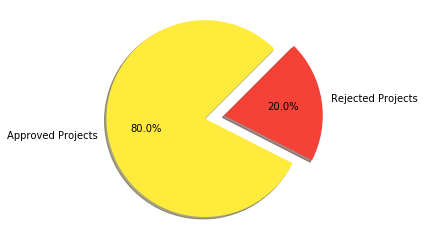

In [14]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'Approved Projects', 'Rejected Projects'
slices_hours = [9.6, 2.4]
colors = ['#FFEB3B','#f44336']
explode = (0.2, 0)  # explode 1st slice
 
# Plot
plt.pie(slices_hours, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=45)
 
plt.axis('equal')
plt.show()

>Observation: Around 80% of submitted projects were Approved.<br>
Its an "Imbalanced" DataSet

## 3.2 Data Cleaning 

### Missing Data

In [49]:
# sum of rows containing null values 
total_NaN_rows = train_res_df[['project_essay_3','project_essay_4','description']].isnull().sum()
percent = (total_NaN_rows/train_res_df[['project_essay_3','project_essay_4','description']].isnull().count()*100)
missing_train_data  = pd.concat([total_NaN_rows, percent], axis=1, keys=['Total_NaN_rows', 'Percent'])
missing_train_data.head()

,Total_NaN_rows,Percent
project_essay_3,1043673,96.472921
project_essay_4,1043673,96.472921
description,192,0.017748


> Observation: Over 96% of the rows dont have Data for Columns project_essay_3 and project_essay_4 so lets ignore these Columns

#### Removing the above columns

In [51]:
train_df = train_df.drop(['project_essay_3','project_essay_4'],axis=1)


train_res_df = train_res_df.drop(['project_essay_3','project_essay_4'],axis=1)

### Removing Duplicate Rows if Any

#### Train Data

In [52]:
train_res_df.shape

(1081830, 17)

In [53]:
train_res_df.duplicated().sum()

8576

> Observation: There are 8576 Duplicated rows in our training data

In [54]:
train_res_df.loc[train_res_df.duplicated(),:][0:5]

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,quantity,price
148,p000139,f68fedcb0852d8a6ce88f7b4139b9227,Mr.,TX,2016-08-07 20:33:16,Grades 9-12,Music & The Arts,Music,Deeds for Reeds,"As I've written here before, we work to use ba...",A guitar can't sound good with broken or worn ...,My students need access to quality replacement...,3,1,Tenor Saxophone Reeds,1,20.95
153,p000139,f68fedcb0852d8a6ce88f7b4139b9227,Mr.,TX,2016-08-07 20:33:16,Grades 9-12,Music & The Arts,Music,Deeds for Reeds,"As I've written here before, we work to use ba...",A guitar can't sound good with broken or worn ...,My students need access to quality replacement...,3,1,Traditional Bb Clarinet Reeds,6,21.95
394,p160114,d523f258b55bb41c3bcb6dd67cfab6c1,Ms.,OK,2016-09-22 01:14:50,Grades PreK-2,"Literacy & Language, Special Needs","Literacy, Special Needs",Bring Our Story to Life,"The students at my school are multicultural, c...",My students struggle with writing. Sometimes ...,"My students need a printer, ink and paper. Th...",0,1,Brother LC109BK - Super High Yield - black - o...,1,32.70
469,p192882,d36c158f9f95db287dc019fe6f00cdad,Mrs.,WI,2016-08-20 11:27:08,Grades PreK-2,Health & Sports,Health & Wellness,Learn and Move,As a teacher in a low-income/high poverty scho...,This past year I noticed how wiggly my student...,"My students need Hokk chairsi, wobble chairs a...",0,0,Norwood Commercial Furniture NOR-STOOLBS-SO Pl...,1,48.95
740,p240306,1ee0a12eeb5da1c2fb438c682c8177dc,Mrs.,GA,2017-03-02 16:57:41,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Create - Evaluate - Celebrate,CREATE - EVALUATE - CELEBRATE!!!!\r\nEach chil...,Osmo states that it enables the iPad to merge ...,My students need to be challenged using techno...,2,1,Osmo Starter Kit,1,79.99


> Observation: These are the sum of the duplicate rows

In [55]:
train_res_df[(train_res_df['id']=='p160114') & (train_res_df['price']==32.7)]

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,description,quantity,price
393,p160114,d523f258b55bb41c3bcb6dd67cfab6c1,Ms.,OK,2016-09-22 01:14:50,Grades PreK-2,"Literacy & Language, Special Needs","Literacy, Special Needs",Bring Our Story to Life,"The students at my school are multicultural, c...",My students struggle with writing. Sometimes ...,"My students need a printer, ink and paper. Th...",0,1,Brother LC109BK - Super High Yield - black - o...,1,32.7
394,p160114,d523f258b55bb41c3bcb6dd67cfab6c1,Ms.,OK,2016-09-22 01:14:50,Grades PreK-2,"Literacy & Language, Special Needs","Literacy, Special Needs",Bring Our Story to Life,"The students at my school are multicultural, c...",My students struggle with writing. Sometimes ...,"My students need a printer, ink and paper. Th...",0,1,Brother LC109BK - Super High Yield - black - o...,1,32.7


> As we can see The above 2 rows are Exactly the same, We are removing these kind of rows.

##### Removing Duplicate rows

In [56]:
train_res_df=train_res_df.drop_duplicates(keep='first', inplace=False)
train_res_df.shape

(1073254, 17)

## 3.3 Lets Understand the data

In [22]:
train_res_df['teacher_number_of_previously_posted_projects'].describe()

count    1.073254e+06
mean     1.256718e+01
std      3.042456e+01
min      0.000000e+00
25%      0.000000e+00
50%      3.000000e+00
75%      1.000000e+01
max      4.510000e+02
Name: teacher_number_of_previously_posted_projects, dtype: float64

-> Observation: 
<ul>
    <li>Max no.of Projects Posted by a Teacher is 45</li>
    <li>75% of the Teachers have posted around 10 Projects</li>
</ul>


### Statewise Submissions

In [26]:
train_df =train_df.sort_values(by=['school_state'])

In [27]:
state_wise_count = train_df[['id','school_state']].groupby('school_state').count()

In [28]:
state_wise_count = state_wise_count.sort_values(by='id',ascending=False)

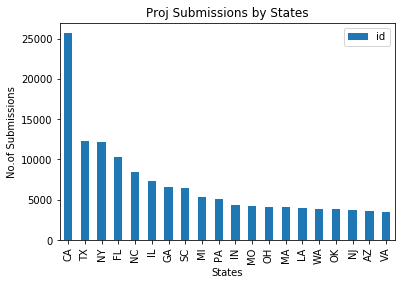

In [29]:
i=np.arange(20)
state_wise_count.head(20).plot(kind='bar')
plt.title('Proj Submissions by States')
plt.xticks(i, state_wise_count.index)
plt.xlabel('States')
plt.ylabel('No.of Submissions')
plt.show()


> Observation: We can observe that Submissions from California is More than other States.

### Count of Projs in each Category

In [30]:
proj_wise_count = train_df[['id','project_subject_categories']].groupby('project_subject_categories').count()

In [31]:
proj_wise_count = proj_wise_count.sort_values(by='id',ascending=False)

In [32]:
# Converting Counts to percentages
proj_wise_count = (proj_wise_count/proj_wise_count.sum()*100)

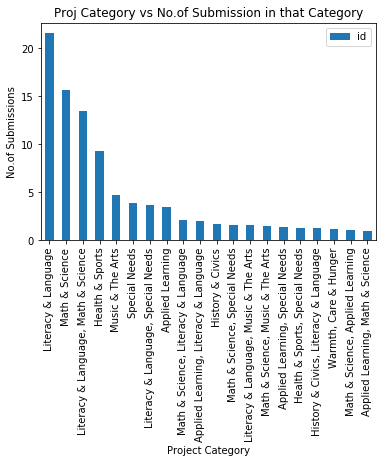

In [33]:
i=np.arange(20)
proj_wise_count.head(20).plot(kind='bar')
plt.title('Proj Category vs No.of Submission in that Category')
plt.xticks(i, proj_wise_count.index)
plt.xlabel('Project Category')
plt.ylabel('No.of Submissions')
plt.show()

In [34]:
proj_wise_count.head(8).sum()

id    75.707931
dtype: float64

> Observation: Top 8 projects Contribute 75% of total Submissions, among which 'Literacy & Language' Category Ranks 1st with 21%.

### Count of Projs in each SubCategory

In [253]:
proj_wise_count = train_df[['id','project_subject_subcategories']].groupby('project_subject_subcategories').count()
proj_wise_count = proj_wise_count.sort_values(by='id',ascending=False)
# Converting Counts to percentages
proj_wise_count = (proj_wise_count/proj_wise_count.sum()*100)

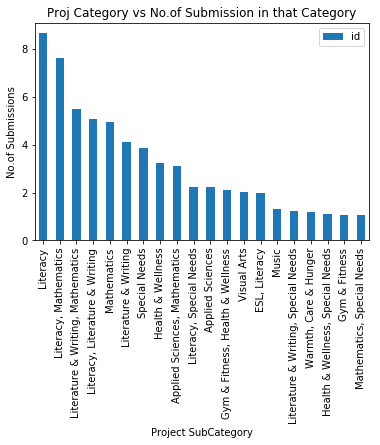

In [259]:
i=np.arange(20)
proj_wise_count.head(20).plot(kind='bar')
plt.title('Proj Category vs No.of Submission in that Category')
plt.xticks(i, proj_wise_count.head(20).index)
plt.xlabel('Project SubCategory')
plt.ylabel('No.of Submissions')
plt.show()

In [258]:
proj_wise_count.head(30).sum()

id    72.283612
dtype: float64

> Observation: These are the Top 20 Sub Categories of the Projects out of which Literacy is highest followed by Literacy n Mathematics

### Lets see freq of Teacher no.of Previously Posted Projects

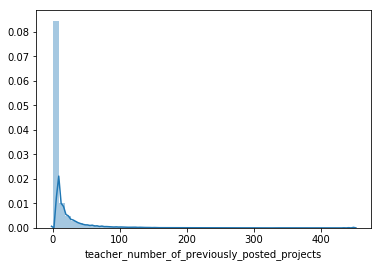

In [45]:
sns.distplot(train_df['teacher_number_of_previously_posted_projects'])

plt.show()



### Lets See Success Rate of Project Approval teacher wise

In [124]:
train_df_subset_cols = train_df[['teacher_id','teacher_number_of_previously_posted_projects','project_is_approved']]

In [132]:
grp_teacher_id = train_df_subset_cols.groupby('teacher_id')
teacher_wise_approved_cnt = list(grp_teacher_id['project_is_approved'].sum())
teacher_wise_proj_cnt = list(grp_teacher_id.apply(len))
teacher_ids = list(grp_teacher_id.apply(len).index)
df_submitted_vs_approved = pd.DataFrame(
    {'teacher_id': teacher_ids,
     'no.of_projs_submitted': teacher_wise_proj_cnt,
     'no.of_projs_approved': teacher_wise_approved_cnt
    })
df_submitted_vs_approved['PercentageOfApproved'] = (df_submitted_vs_approved['no.of_projs_approved']/df_submitted_vs_approved['no.of_projs_submitted'])*100

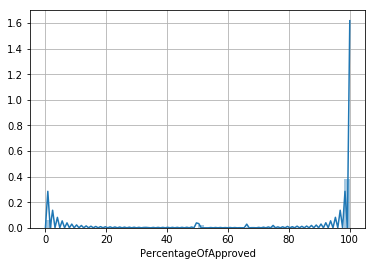

In [214]:
sns.distplot(df_submitted_vs_approved['PercentageOfApproved'])
plt.grid()
plt.show()

Text(0.5,1,'Correlation between Projects Approved vs Projects Submitted by a Teacher')

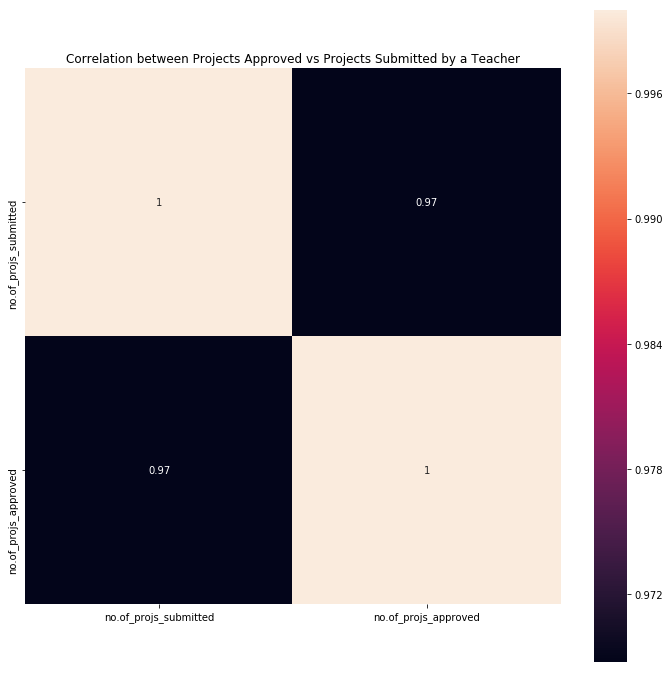

In [283]:
correlation = df_submitted_vs_approved[['no.of_projs_submitted','no.of_projs_approved']].corr()
plt.figure(figsize=(12,12))
sns.heatmap(correlation, 
            xticklabels=correlation.columns.values,
            yticklabels=correlation.columns.values, annot=True, square=True)
plt.title('Correlation between Projects Approved vs Projects Submitted by a Teacher')


In [194]:
df_submitted_vs_approved['PercentageOfApproved'] = df_submitted_vs_approved['PercentageOfApproved'].astype(int)

In [247]:
count_at_that_percentage = df_submitted_vs_approved.groupby('PercentageOfApproved').apply(len)

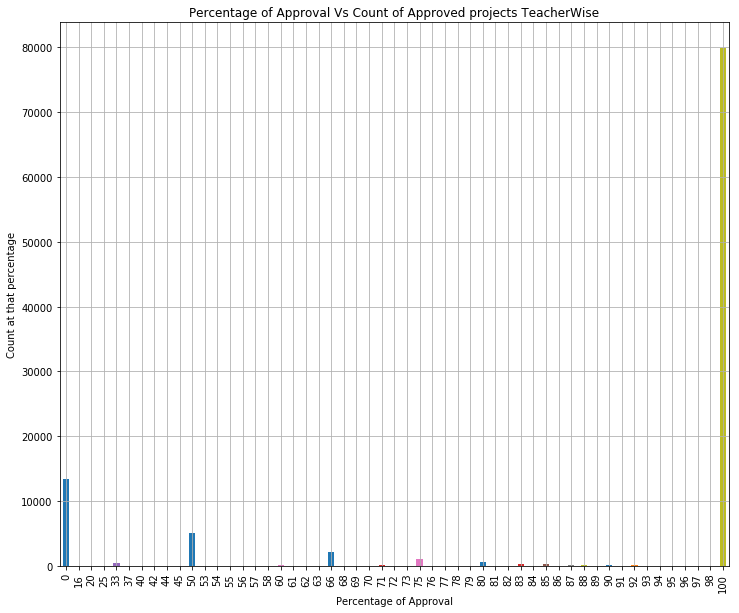

In [250]:
i=np.arange(53)
plt.figure(figsize=(12,10))
count_at_that_percentage.head(53).plot(kind='bar')
plt.title('Percentage of Approval Vs Count of Approved projects TeacherWise')
plt.xticks(i, count_at_that_percentage.head(53).index)
plt.xlabel('Percentage of Approval')
plt.ylabel('Count at that percentage')
plt.grid()
plt.show()

Explanation: We have calculated, Teacher wise "projects_approved/projects_submitted percentage" then performed Groupby on Percentage calculated to get the insights of success rate of teacher wise projects Approval.

> Observation: We can see that in case of Most of the teachers the approval rate is 100%, followed by 0% for some of the teachers. 

### School Grade wise Project submissions

In [270]:
grade_wise_count = train_df[['id','project_grade_category']].groupby('project_grade_category').count()
grade_wise_count = proj_wise_count.sort_values(by='id',ascending=False)
# Converting Counts to percentages
grade_wise_count = (proj_wise_count/proj_wise_count.sum()*100)

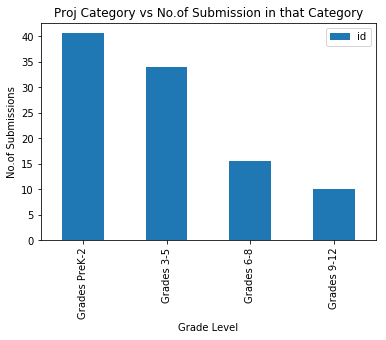

In [271]:
i=np.arange(4)
grade_wise_count.head(4).plot(kind='bar')
plt.title('Proj Category vs No.of Submission in that Category')
plt.xlabel('Grade Level')
plt.ylabel('No.of Submissions')
plt.show()

# Data Preprocessing

## Lets Remove unnecessary Features

In [64]:
train_res_df = train_res_df.sort_values(by=['project_submitted_datetime'])

In [66]:
train_res_df['Price'] = train_res_df['quantity']*train_res_df['price']

In [67]:
train_res_df = train_res_df.drop(['quantity','price'],axis=1)

In [83]:
'''pickle_out=open("beforeFeatures_Removal.pickle","wb")
pickle.dump(train_res_df,pickle_out)
pickle_out.close()'''

In [68]:
train_res_dim_df = train_res_df.drop(['id','teacher_id','project_submitted_datetime','project_title','project_resource_summary','description'],axis=1)

## Lets Convert Categorical and text Features to Numerical Features

In [69]:
train_res_dim_df.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_essay_1,project_essay_2,teacher_number_of_previously_posted_projects,project_is_approved,Price
763814,Ms.,CA,Grades 6-8,Math & Science,Applied Sciences,I love giving my students experiences. A new e...,My students can vary quite dramatically. I hav...,30,1,596.00
1028203,Ms.,TX,Grades PreK-2,"Literacy & Language, Math & Science","Foreign Languages, Mathematics","We are getting closer to the end of the year, ...",Welcome to our Pre-K classroom. We work hard e...,1,1,9.99
1028198,Ms.,TX,Grades PreK-2,"Literacy & Language, Math & Science","Foreign Languages, Mathematics","We are getting closer to the end of the year, ...",Welcome to our Pre-K classroom. We work hard e...,1,1,29.99
1028199,Ms.,TX,Grades PreK-2,"Literacy & Language, Math & Science","Foreign Languages, Mathematics","We are getting closer to the end of the year, ...",Welcome to our Pre-K classroom. We work hard e...,1,1,29.99
1028200,Ms.,TX,Grades PreK-2,"Literacy & Language, Math & Science","Foreign Languages, Mathematics","We are getting closer to the end of the year, ...",Welcome to our Pre-K classroom. We work hard e...,1,1,29.99


In our Data Set we have some categorical features like teacher_prefix, school_state,grade etc.. lets convert them to Numerical features

In [70]:
categorical_features = ['teacher_prefix','school_state','project_grade_category']

for feature in categorical_features:
    num = LabelEncoder()
    train_res_dim_df[feature] = num.fit_transform(train_res_dim_df[feature].astype('str'))

In [71]:
train_res_dim_df.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_essay_1,project_essay_2,teacher_number_of_previously_posted_projects,project_is_approved,Price
763814,3,4,1,Math & Science,Applied Sciences,I love giving my students experiences. A new e...,My students can vary quite dramatically. I hav...,30,1,596.00
1028203,3,43,3,"Literacy & Language, Math & Science","Foreign Languages, Mathematics","We are getting closer to the end of the year, ...",Welcome to our Pre-K classroom. We work hard e...,1,1,9.99
1028198,3,43,3,"Literacy & Language, Math & Science","Foreign Languages, Mathematics","We are getting closer to the end of the year, ...",Welcome to our Pre-K classroom. We work hard e...,1,1,29.99
1028199,3,43,3,"Literacy & Language, Math & Science","Foreign Languages, Mathematics","We are getting closer to the end of the year, ...",Welcome to our Pre-K classroom. We work hard e...,1,1,29.99
1028200,3,43,3,"Literacy & Language, Math & Science","Foreign Languages, Mathematics","We are getting closer to the end of the year, ...",Welcome to our Pre-K classroom. We work hard e...,1,1,29.99


> Observation: As we can see The Categorical Features are converted to numerical Features

### Lets Combine project_subject_categories and subcategories

In [72]:
train_res_dim_df['project_subject'] = train_res_dim_df[['project_subject_categories','project_subject_subcategories']].apply(lambda a : ' '.join(a),axis=1)

In [73]:
train_res_dim_df = train_res_dim_df.drop(['project_subject_categories','project_subject_subcategories'],axis=1)
train_res_dim_df['project_subject'].head()

763814                       Math & Science Applied Sciences
1028203    Literacy & Language, Math & Science Foreign La...
1028198    Literacy & Language, Math & Science Foreign La...
1028199    Literacy & Language, Math & Science Foreign La...
1028200    Literacy & Language, Math & Science Foreign La...
Name: project_subject, dtype: object

#### Lets Convert Project Subject into word vector

In [74]:
#considering only unigrams as text contains less no.of words
tfidf_vect = TfidfVectorizer(ngram_range=(1,1))

proj_subject_vector = tfidf_vect.fit_transform(train_res_dim_df['project_subject'])

In [75]:
proj_subject_vector.shape

(1073254, 52)

### Lets Combine Project essay 1 and Project essay 2

In [76]:
train_res_dim_df['about_project'] = train_res_dim_df[['project_essay_1', 'project_essay_2']].apply(lambda x: ' '.join(x), axis=1)

In [77]:
train_res_dim_df = train_res_dim_df.drop(['project_essay_1','project_essay_2'],axis=1)

#### Lets Clean the Text

In [78]:
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

In [79]:
start = datetime.now()
i=0
str1=' '
final_string=[]
stop = set(stopwords.words('english'))

for sent in train_res_dim_df['about_project'].values:
    filtered_sentence=[]
    
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    filtered_sentence.append(cleaned_words.lower())    
                else:
                    continue
            else:
                continue 
    
    #final string of cleaned words
    str1 = " ".join(filtered_sentence) 
   
    
    final_string.append(str1)
    i+=1
    if(i%10000==0):
        print("No of Sentences processed: ",i)
print("Time Taken To Clean the data is: ",datetime.now() -start)

No of Sentences processed:  10000
No of Sentences processed:  20000
No of Sentences processed:  30000
No of Sentences processed:  40000
No of Sentences processed:  50000
No of Sentences processed:  60000
No of Sentences processed:  70000
No of Sentences processed:  80000
No of Sentences processed:  90000
No of Sentences processed:  100000
No of Sentences processed:  110000
No of Sentences processed:  120000
No of Sentences processed:  130000
No of Sentences processed:  140000
No of Sentences processed:  150000
No of Sentences processed:  160000
No of Sentences processed:  170000
No of Sentences processed:  180000
No of Sentences processed:  190000
No of Sentences processed:  200000
No of Sentences processed:  210000
No of Sentences processed:  220000
No of Sentences processed:  230000
No of Sentences processed:  240000
No of Sentences processed:  250000
No of Sentences processed:  260000
No of Sentences processed:  270000
No of Sentences processed:  280000
No of Sentences processed:  2

In [80]:
train_res_dim_df['cleaned_about_project'] = final_string

In [81]:
train_res_dim_df.head()

,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,Price,project_subject,about_project,cleaned_about_project
763814,3,4,1,30,1,596.00,Math & Science Applied Sciences,I love giving my students experiences. A new e...,love giving students experiences new experienc...
1028203,3,43,3,1,1,9.99,"Literacy & Language, Math & Science Foreign La...","We are getting closer to the end of the year, ...",getting closer end year still lot work get don...
1028198,3,43,3,1,1,29.99,"Literacy & Language, Math & Science Foreign La...","We are getting closer to the end of the year, ...",getting closer end year still lot work get don...
1028199,3,43,3,1,1,29.99,"Literacy & Language, Math & Science Foreign La...","We are getting closer to the end of the year, ...",getting closer end year still lot work get don...
1028200,3,43,3,1,1,29.99,"Literacy & Language, Math & Science Foreign La...","We are getting closer to the end of the year, ...",getting closer end year still lot work get don...


In [82]:
'''pickle_out=open("cleanedData.pickle","wb")
pickle.dump(proj_subject_vector,pickle_out)
pickle.dump(final_string,pickle_out)
pickle.dump(train_res_dim_df,pickle_out)
pickle_out.close()'''

In [2]:
pickle_in=open("cleanedData.pickle","rb")
proj_subject_vector = pickle.load(pickle_in)
final_string = pickle.load(pickle_in)
train_res_dim_df = pickle.load(pickle_in)
pickle_in.close()

In [11]:
proj_subject_vector

<1073254x52 sparse matrix of type '<class 'numpy.float64'>'
	with 4683669 stored elements in Compressed Sparse Row format>

In [8]:
'''pickle_out=open("projSubjVector.pickle","wb")
pickle.dump(proj_subject_vector,pickle_out)
pickle_out.close()'''

In [3]:
pickle_in=open("projSubjVector.pickle","rb")
proj_subject_vector = pickle.load(pickle_in)

pickle_in.close()

#### Lets Convert 'about project' into word vector

In [8]:
start = datetime.now()
#considering bigrams
tfidf_bigram_vect = TfidfVectorizer(ngram_range=(1,2))

about_proj_vector = tfidf_bigram_vect.fit_transform(train_res_dim_df['cleaned_about_project'][0:600000])
print("Time Taken: ",datetime.now() -start)

Time Taken:  0:02:49.768380


In [10]:
about_proj_vector.shape

(600000, 2273955)

In [12]:
'''pickle_out=open("tfidf_vect_projEssay_30000dp.pickle","wb")
pickle.dump(train_res_dim_df,pickle_out)
pickle.dump(about_proj_vector,pickle_out)
pickle.dump(proj_subject_vector,pickle_out)
pickle_out.close()'''

In [13]:
#del train_res_dim_df,about_proj_vector,proj_subject_vector

In [5]:
pickle_in=open("tfidf_vect_projEssay_30000dp.pickle","rb")
train_res_dim_df = pickle.load(pickle_in)
about_proj_vector = pickle.load(pickle_in)
proj_subject_vector = pickle.load(pickle_in)
pickle_in.close()

In [11]:
train_res_dim_df = train_res_dim_df[0:600000]

In [12]:
scaler = StandardScaler()
features = ['teacher_prefix','school_state', 'project_grade_category','teacher_number_of_previously_posted_projects', 'Price']

for feature in features:
    train_res_dim_df[feature] = scaler.fit_transform(train_res_dim_df[feature].astype(np.float64).values.reshape(-1, 1))


# Machine Learning Models

### Features Considered
<ul>
    <li>Teacher Prefix</li>
    <li>School State</li>
    <li>Project Grade Category</li>
    <li>Teacher no.of Previously posted Projects</li>
    <li>Price</li>
    <li>Project Subject(tfidf vector)</li>
    <li>Project Essays(tfidf vector)</li>
</ul>

### Datapoints Considered
-> 600000(6 lakhs) out of 1000000(~10 lakhs) datapoints

### Considered ML Models
#### LightGBM with GBDT,  RF with Logloss
-> As it is very suitable for large amount of data, unlike other boosting algorithms LGB grows the tree leaf wise(so that loss will be less), where as other algo(XGB) grows level wise.

#### XGB
-> SKLearn's implementation is taking huge amount of time, so used XGB.Train, its very fast when compared to SKLearn's implimentation.

In [ ]:
X = hstack((train_res_dim_df[['teacher_prefix', 'school_state', 'project_grade_category',
       'teacher_number_of_previously_posted_projects',
       'Price']],proj_subject_vector[0:600000],about_proj_vector))

In [14]:
X = X.tocsr()

In [15]:
Y = train_res_dim_df['project_is_approved'].to_sparse().as_matrix()

In [50]:
'''pickle_out=open("train_test_Split_data.pickle","wb")
pickle.dump(X,pickle_out)
pickle.dump(Y,pickle_out)
pickle_out.close()'''

In [2]:
'''pickle_in=open("train_test_Split_data.pickle","rb")
X = pickle.load(pickle_in)
Y = pickle.load(pickle_in)
pickle_in.close()'''

In [18]:
x_train = X[0:550000]
x_test = X[550000:600000]

In [19]:
y_train = Y[0:550000]
y_test = Y[550000:600000]

In [20]:
y_train.sum()

429497

In [21]:
y_train.sum()/y_train.shape[0]

0.7809036363636364

In [5]:
def confusionMatrix(y_test,pred):
    df_cm = pd.DataFrame(confusion_matrix(y_test, pred), index = ['False','True'],
                      columns = ['False','True'])
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm, annot=True,fmt='d')
    
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.figure(figsize=(12,10))
    plt.show()
def auc_roc(y_test,pred):
    fpr, tpr, thresholds = roc_curve(y_test,pred)
    acc = roc_auc_score(y_test,pred)
    print("Area Under The Curve is : ",acc)
    
    plt.figure(figsize=(10,8))
    plt.plot(fpr, tpr, color='darkorange',
              label='ROC curve (area/auc = %0.2f)' % acc)
    plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([0, 1])
    #plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

## LGB with GDBT Logloss

In [16]:
def train_lgb(boosting_type='gbdt',max_depth=7,num_leaves=32,learning_rate=0.02,n_iter=1000,early_stopping_rounds=25,verbose_eval=25):
    params = {
        'boosting_type': boosting_type,
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': max_depth,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'feature_fraction': 0.80,
        'bagging_fraction': 0.80,
        'bagging_freq': 5,
        'verbose': 0,
        'lambda_l2': 1,
        
    }  
    evals_result = {}  # to record eval results for plotting
    model_lgb = lgb.train(
            params,
            lgb.Dataset(x_train, y_train),
            num_boost_round=n_iter,
            valid_sets=[lgb.Dataset(x_test, y_test)],
            early_stopping_rounds=early_stopping_rounds,
            evals_result=evals_result,
            verbose_eval=verbose_eval)
    return model_lgb

In [4]:
def eval_model(model,x_test,y_test):
    y_preds = model_lgb.predict(x_test, num_iteration=model.best_iteration)
    pred = [1 if i>=0.56 else 0 for i in y_preds]
    confusionMatrix(y_test,pred)
    auc_roc(y_test,y_preds)
    print(roc_auc_score(y_test, y_preds))

In [33]:
'''pickle_out=open("lgb_73_auc.pickle","wb")
pickle.dump(model_lgb,pickle_out)
pickle.dump(evals_result,pickle_out)
pickle.dump(x_train,pickle_out)
pickle.dump(y_train,pickle_out)
pickle.dump(x_test,pickle_out)
pickle.dump(y_test,pickle_out)
pickle_out.close()'''

In [2]:
pickle_in=open("lgb_73_auc.pickle","rb")
model_lgb = pickle.load(pickle_in)
evals_result = pickle.load(pickle_in)
x_train = pickle.load(pickle_in)
y_train = pickle.load(pickle_in)
x_test = pickle.load(pickle_in)
y_test = pickle.load(pickle_in)
pickle_in.close()

In [101]:
model_4 = train_lgb(max_depth=5,num_leaves=31)

Training until validation scores don't improve for 25 rounds.
[25]	valid_0's auc: 0.68464
[50]	valid_0's auc: 0.694064
[75]	valid_0's auc: 0.700353
[100]	valid_0's auc: 0.704777
[125]	valid_0's auc: 0.707801
[150]	valid_0's auc: 0.709807
[175]	valid_0's auc: 0.713009
[200]	valid_0's auc: 0.714266
[225]	valid_0's auc: 0.715773
[250]	valid_0's auc: 0.71704
[275]	valid_0's auc: 0.718327
[300]	valid_0's auc: 0.719557
[325]	valid_0's auc: 0.720502
[350]	valid_0's auc: 0.72107
[375]	valid_0's auc: 0.721646
[400]	valid_0's auc: 0.722464
[425]	valid_0's auc: 0.72251
[450]	valid_0's auc: 0.722975
[475]	valid_0's auc: 0.724223
[500]	valid_0's auc: 0.724883
[525]	valid_0's auc: 0.72524
[550]	valid_0's auc: 0.725621
[575]	valid_0's auc: 0.726088
[600]	valid_0's auc: 0.726318
[625]	valid_0's auc: 0.726488
[650]	valid_0's auc: 0.726932
Early stopping, best iteration is:
[648]	valid_0's auc: 0.726983


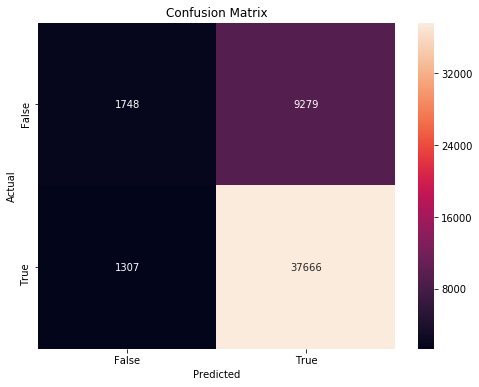

<Figure size 864x720 with 0 Axes>

Area Under The Curve is :  0.7362143395327896


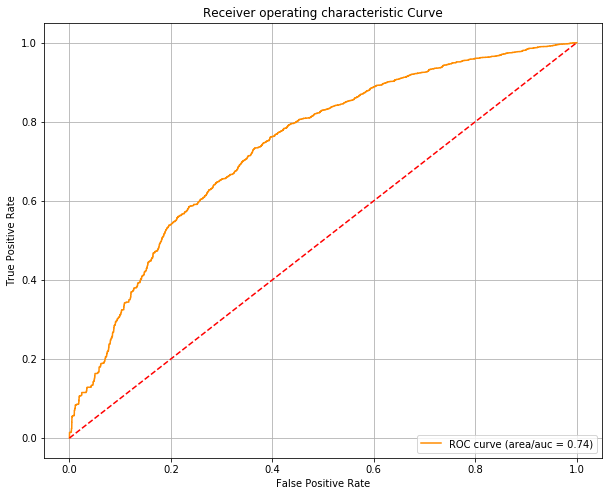

0.7362143395327896


In [102]:
eval_model(model_4,x_test,y_test)

> Observation: We got 73.62% auc with max depth of 5 and num of leaves 31

In [103]:
model_2 = train_lgb(max_depth=10,num_leaves=32)

Training until validation scores don't improve for 25 rounds.
[25]	valid_0's auc: 0.687231
[50]	valid_0's auc: 0.693827
[75]	valid_0's auc: 0.701479
[100]	valid_0's auc: 0.707053
[125]	valid_0's auc: 0.71091
[150]	valid_0's auc: 0.714267
[175]	valid_0's auc: 0.717517
[200]	valid_0's auc: 0.719935
[225]	valid_0's auc: 0.721314
[250]	valid_0's auc: 0.723573
[275]	valid_0's auc: 0.724243
[300]	valid_0's auc: 0.725146
[325]	valid_0's auc: 0.726404
[350]	valid_0's auc: 0.727558
[375]	valid_0's auc: 0.728129
[400]	valid_0's auc: 0.72902
[425]	valid_0's auc: 0.729419
[450]	valid_0's auc: 0.729927
[475]	valid_0's auc: 0.730834
[500]	valid_0's auc: 0.730839
[525]	valid_0's auc: 0.730855
[550]	valid_0's auc: 0.731623
[575]	valid_0's auc: 0.73181
[600]	valid_0's auc: 0.732272
[625]	valid_0's auc: 0.732075
Early stopping, best iteration is:
[600]	valid_0's auc: 0.732272


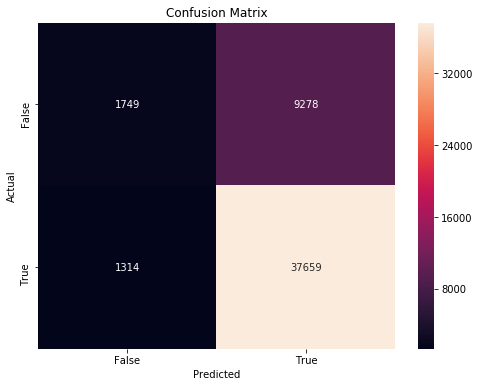

<Figure size 864x720 with 0 Axes>

Area Under The Curve is :  0.7361099568689176


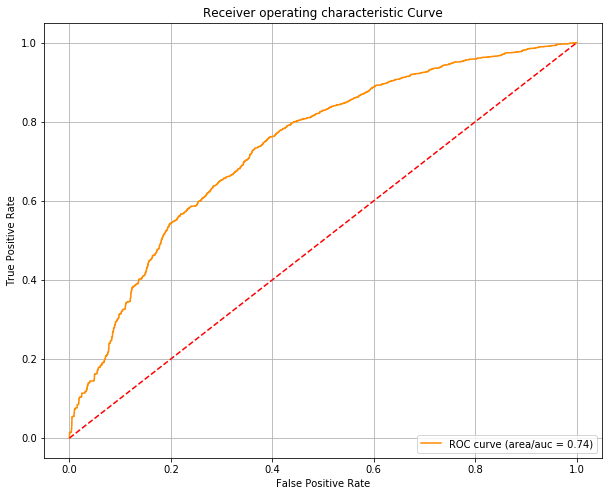

0.7361099568689176


In [104]:
eval_model(model_2,x_test,y_test)

In [99]:
model_5 = train_lgb(max_depth=15,num_leaves=34)

Training until validation scores don't improve for 25 rounds.
[25]	valid_0's auc: 0.688052
[50]	valid_0's auc: 0.693504
[75]	valid_0's auc: 0.700195
[100]	valid_0's auc: 0.705473
[125]	valid_0's auc: 0.709644
[150]	valid_0's auc: 0.713047
[175]	valid_0's auc: 0.717415
[200]	valid_0's auc: 0.719261
[225]	valid_0's auc: 0.721231
[250]	valid_0's auc: 0.72407
[275]	valid_0's auc: 0.725705
[300]	valid_0's auc: 0.727213
[325]	valid_0's auc: 0.728402
[350]	valid_0's auc: 0.729505
[375]	valid_0's auc: 0.730306
[400]	valid_0's auc: 0.731149
[425]	valid_0's auc: 0.732164
[450]	valid_0's auc: 0.732902
[475]	valid_0's auc: 0.733736
[500]	valid_0's auc: 0.734451
[525]	valid_0's auc: 0.734991
[550]	valid_0's auc: 0.735491
[575]	valid_0's auc: 0.735616
[600]	valid_0's auc: 0.73611
[625]	valid_0's auc: 0.736115
Early stopping, best iteration is:
[615]	valid_0's auc: 0.736214


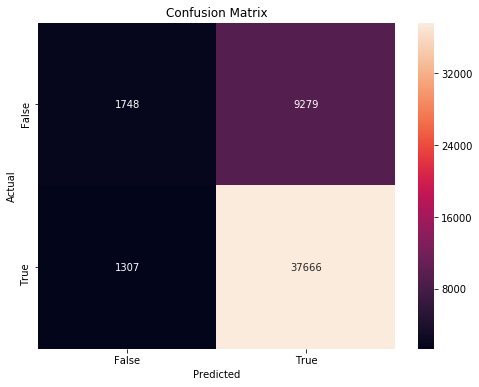

<Figure size 864x720 with 0 Axes>

Area Under The Curve is :  0.7362143395327896


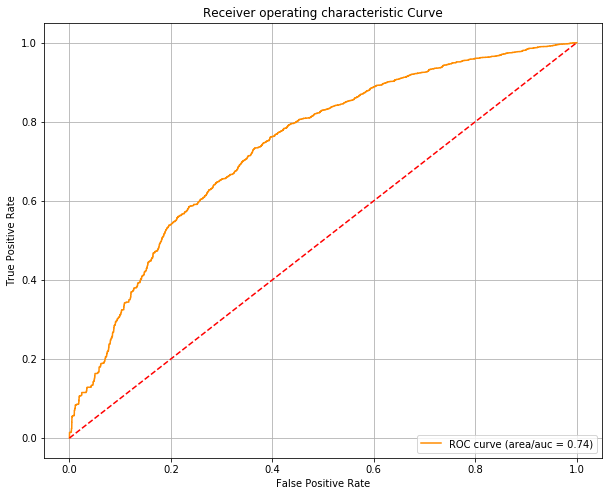

0.7362143395327896


In [100]:
eval_model(model_5,x_test,y_test)

In [89]:
model_3 = train_lgb(max_depth=20,num_leaves=36)

Training until validation scores don't improve for 25 rounds.
[25]	valid_0's auc: 0.688247
[50]	valid_0's auc: 0.693721
[75]	valid_0's auc: 0.698523
[100]	valid_0's auc: 0.703893
[125]	valid_0's auc: 0.70977
[150]	valid_0's auc: 0.714765
[175]	valid_0's auc: 0.717977
[200]	valid_0's auc: 0.720522
[225]	valid_0's auc: 0.7231
[250]	valid_0's auc: 0.726449
[275]	valid_0's auc: 0.727878
[300]	valid_0's auc: 0.729583
[325]	valid_0's auc: 0.730745
[350]	valid_0's auc: 0.731601
[375]	valid_0's auc: 0.731693
[400]	valid_0's auc: 0.732587
[425]	valid_0's auc: 0.733135
[450]	valid_0's auc: 0.73422
[475]	valid_0's auc: 0.734378
Early stopping, best iteration is:
[463]	valid_0's auc: 0.734522


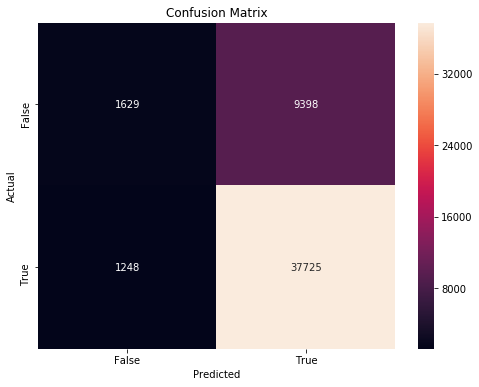

<Figure size 864x720 with 0 Axes>

Area Under The Curve is :  0.7333860670669936


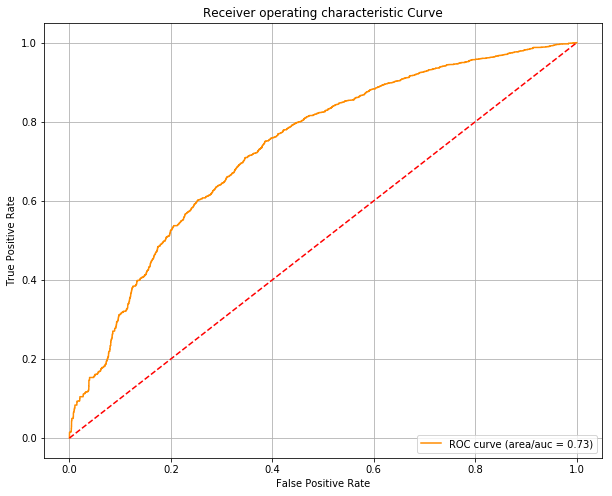

0.7333860670669936


In [91]:
eval_model(model_3,x_test,y_test)

##  LGB with dart

In [7]:
model_6 = train_lgb(max_depth=17,num_leaves=32,boosting_type='dart',verbose_eval=50,early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.688282
[100]	valid_0's auc: 0.691996
[150]	valid_0's auc: 0.693841
[200]	valid_0's auc: 0.697024
[250]	valid_0's auc: 0.698929
[300]	valid_0's auc: 0.702231
[350]	valid_0's auc: 0.704424
[400]	valid_0's auc: 0.705745
[450]	valid_0's auc: 0.708638
[500]	valid_0's auc: 0.710391
[550]	valid_0's auc: 0.711689
[600]	valid_0's auc: 0.712798
[650]	valid_0's auc: 0.714765
[700]	valid_0's auc: 0.715741
[750]	valid_0's auc: 0.716624
[800]	valid_0's auc: 0.717364
[850]	valid_0's auc: 0.717697
[900]	valid_0's auc: 0.718748
[950]	valid_0's auc: 0.720449
[1000]	valid_0's auc: 0.72225
Did not meet early stopping. Best iteration is:
[997]	valid_0's auc: 0.722425


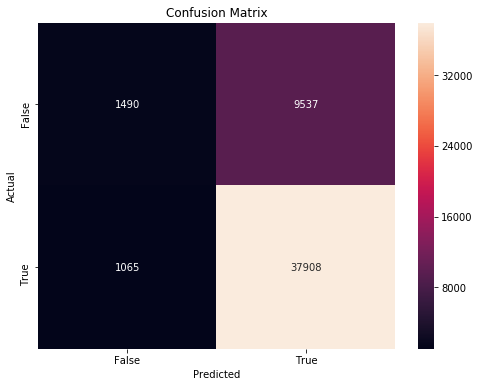

<Figure size 864x720 with 0 Axes>

Area Under The Curve is :  0.7307559887962376


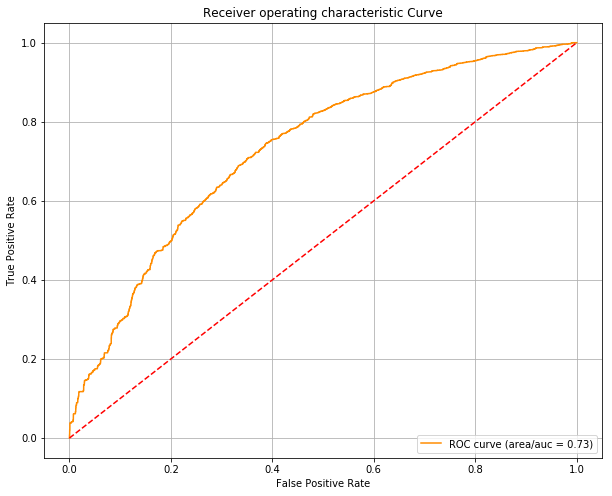

0.7307559887962376


In [8]:
eval_model(model_6,x_test,y_test)

## LGB with RF

In [10]:
model_rf1 = train_lgb(max_depth=15,num_leaves=34,early_stopping_rounds=50,boosting_type='rf')

Training until validation scores don't improve for 50 rounds.
[25]	valid_0's auc: 0.681144
[50]	valid_0's auc: 0.683841
[75]	valid_0's auc: 0.685312
[100]	valid_0's auc: 0.685079
[125]	valid_0's auc: 0.685956
Early stopping, best iteration is:
[86]	valid_0's auc: 0.686144


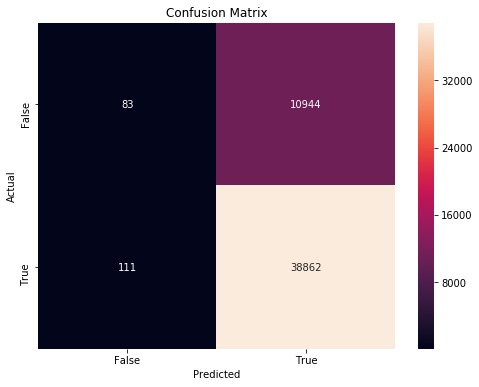

<Figure size 864x720 with 0 Axes>

Area Under The Curve is :  0.7013505926260064


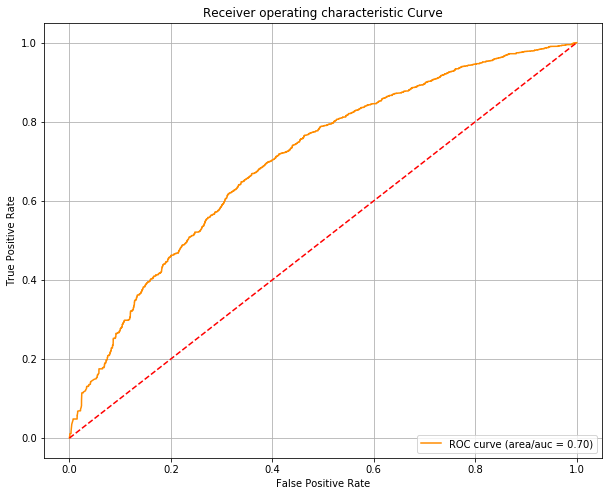

0.7013505926260064


In [11]:
eval_model(model_rf1,x_test,y_test)

> observation: we got 70% auc with max depth as 15 and no.of leaves 34 using Random Forest

## XGBOOST

In [36]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
xgb_params = {'eta': 0.2,  #learning_rate
                  'max_depth': 10, 
                  'subsample': 0.8, 
                  'colsample_bytree': 0.8, 
                  'objective': 'binary:logistic', 
                  'eval_metric': 'auc', 
                  'seed': 1234
                 }

d_train = xgb.DMatrix(x_train, y_train)
d_valid = xgb.DMatrix(x_test, y_test)


#watchlist -> List of items to be evaluated during training, this allows user to watch performance on the validation set.
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model_xgb = xgb.train(xgb_params, d_train, 200, watchlist, verbose_eval=25, early_stopping_rounds=5)

xgb_pred_valid = model_xgb.predict(d_valid)
auc = roc_auc_score(y_test, xgb_pred_valid)
print('AUC:',auc)

[12:23:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[0]	train-auc:0.704752	valid-auc:0.660359
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 5 rounds.
[12:23:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=10
[12:24:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=10
[12:24:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[12:25:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[12:25:45] C:\Users\Administrator\Desktop\xgboost\s

Area Under The Curve is :  0.7034069583290812


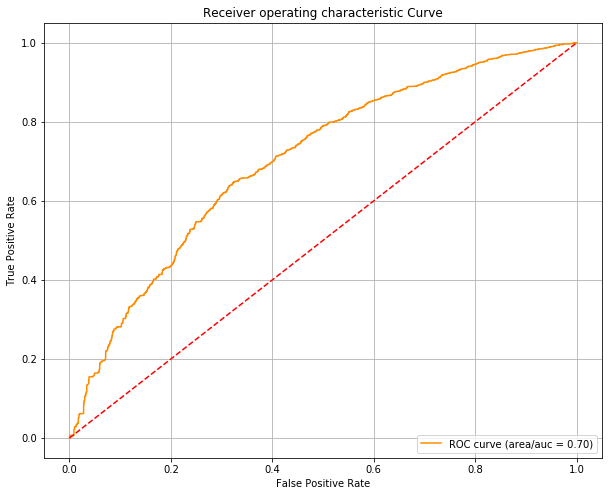

In [37]:
auc_roc(y_test, xgb_pred_valid)

> Observation: We got 70% auc with max depth of 10 using XGB logloss

In [38]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
xgb_params = {'eta': 0.2,  #learning_rate
                  'max_depth': 15, 
                  'subsample': 0.8, 
                  'colsample_bytree': 0.8, 
                  'objective': 'binary:logistic',  #logloss
                  'eval_metric': 'auc', 
                  'seed': 1234
                 }

d_train = xgb.DMatrix(x_train, y_train)
d_valid = xgb.DMatrix(x_test, y_test)


#watchlist -> List of items to be evaluated during training, this allows user to watch performance on the validation set.
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model_xgb = xgb.train(xgb_params, d_train, 200, watchlist, verbose_eval=50, early_stopping_rounds=10)

xgb_pred_valid = model_xgb.predict(d_valid)
auc = roc_auc_score(y_test, xgb_pred_valid)
print('AUC:',auc)

[13:12:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1412 extra nodes, 0 pruned nodes, max_depth=15
[0]	train-auc:0.752003	valid-auc:0.652809
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[13:13:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1462 extra nodes, 0 pruned nodes, max_depth=15
[13:14:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1438 extra nodes, 0 pruned nodes, max_depth=15
[13:14:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1232 extra nodes, 0 pruned nodes, max_depth=15
[13:15:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 990 extra nodes, 0 pruned nodes, max_depth=15
[13:16:05] C:\Users\Administrator\Desktop\xgbo

In [39]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
xgb_params = {'eta': 0.2,  #learning_rate
                  'max_depth': 5, 
                  'subsample': 0.8, 
                  'colsample_bytree': 0.8, 
                  'objective': 'binary:logistic',  #logloss
                  'eval_metric': 'auc', 
                  'seed': 1234
                 }

d_train = xgb.DMatrix(x_train, y_train)
d_valid = xgb.DMatrix(x_test, y_test)


#watchlist -> List of items to be evaluated during training, this allows user to watch performance on the validation set.
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model_xgb = xgb.train(xgb_params, d_train, 200, watchlist, verbose_eval=50, early_stopping_rounds=5)

xgb_pred_valid = model_xgb.predict(d_valid)
auc = roc_auc_score(y_test, xgb_pred_valid)
print('AUC:',auc)

[13:39:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-auc:0.663331	valid-auc:0.652078
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 5 rounds.
[13:39:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[13:39:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[13:39:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[13:39:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[13:40:01] C:\Users\Administrator\Desktop\xgboost\src\tree\up

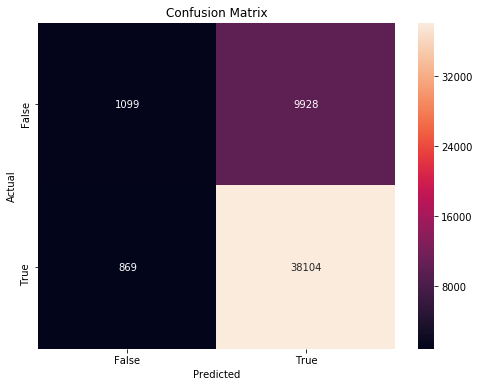

<Figure size 864x720 with 0 Axes>

In [43]:
pred = [1 if i>=0.56 else 0 for i in xgb_pred_valid]
confusionMatrix(y_test,pred)

Area Under The Curve is :  0.712009960431643


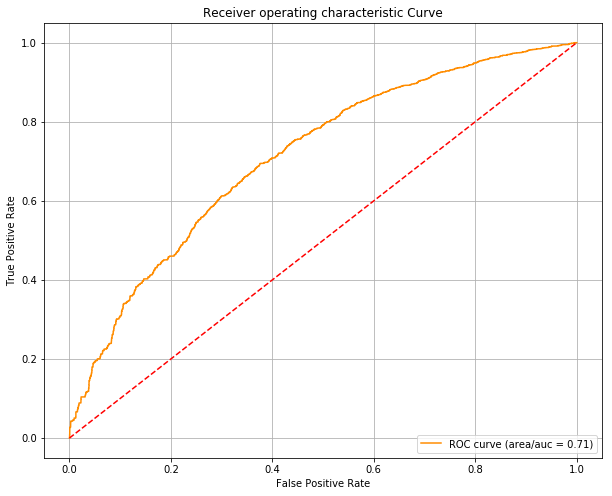

In [49]:
auc_roc(y_test,xgb_pred_valid)

> Observation: auc is 71% with max_depth of 5.

# Summary:
Best model is Light GBM with gbdt using Logloss it gave 74% AUC.